In [33]:
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data as utils
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Models import LSTM, GRU
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from functions import *
import csv

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [35]:
seq_len = 100
batch_size = 256
input_size = 1
hidden_size = 512
num_of_rec_layers = 2
output_size = 1

model = GRU(input_size, hidden_size,num_of_rec_layers, output_size)
model.to(device)
model.load_state_dict(torch.load("./trained_models/GRU_1_sl100.tar", map_location=device))

<All keys matched successfully>

In [55]:
path_test = 'data/inverse_pendulum_10Hz/dane_testowe_10Hz.txt'
path_test_force = 'data/inverse_pendulum_10Hz/dane_testowe_10Hz_fmax100.txt'
# path_test_force = 'data/inverse_pendulum_10Hz/dane_testowe_10Hz_fmax200.txt'

test_loader = data_prep(path_test, seq_len=seq_len, batch_size=batch_size, data_shuffle=False)
test_loader_force = data_prep(path_test_force, seq_len=seq_len, batch_size=batch_size, data_shuffle=False)

Min angle value -2.809310509060064, max angle value -0.3013423500872326
Min angle value -4.098105445048617, max angle value 0.9729173982001134


In [56]:
model.eval()

loss = 0

predicted_angles = []
true_angles = []
force_vect = []
k = 0
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader_force):

        x = x.view(-1, seq_len, input_size).requires_grad_().to(device)
        # optimizer.zero_grad()
        hidden = model.init_hidden(x).to(device)
        # x, y = x.to(device), y.to(device)
        x = x.to(device)
        preds = model(x, hidden) 

        predicted_angles.append(preds.detach().cpu().numpy())
        true_angles.append(y.detach().cpu().numpy())
        force_vect.append(x.detach().cpu().numpy())

predicted_angles = np.concatenate(predicted_angles, axis=0)
true_angles = np.concatenate(true_angles, axis=0)
force_vect = np.concatenate(force_vect, axis=0)

loss = mean_absolute_error(predicted_angles, true_angles)
print(f'Model loss: {loss:.4f}')

Model loss: 0.1056


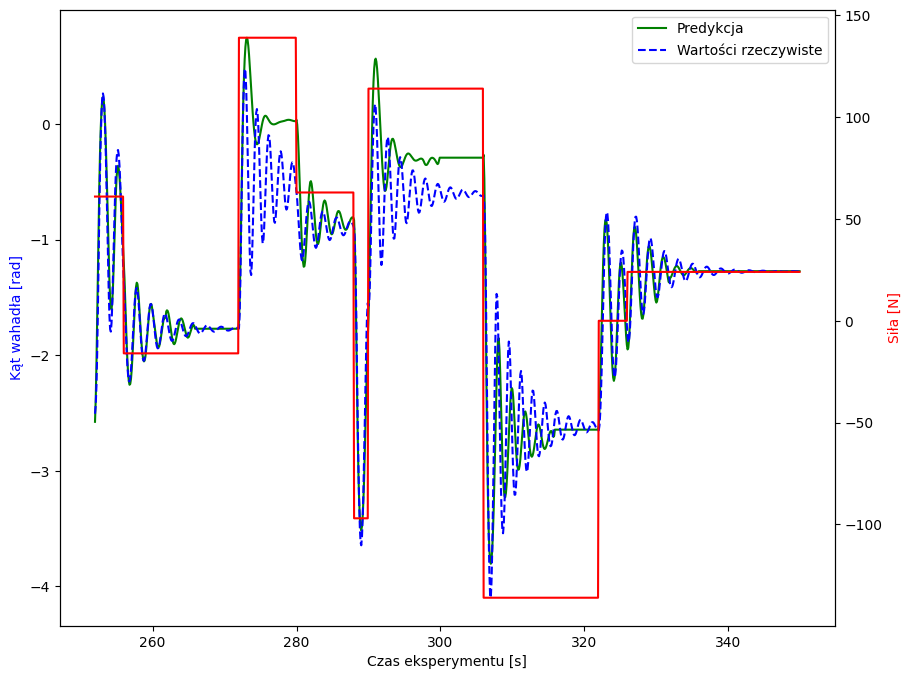

In [58]:
t =[i * 0.1 for i in range(len(predicted_angles))]
st = 2520
en = 3500
# st = 1500
# en = 2500
fig, ax1 = plt.subplots(figsize=(10, 8))

ax2 = ax1.twinx()

ax1.plot(t[st:en],predicted_angles[st:en], label='Predykcja', color='g')
ax1.plot(t[st:en],true_angles[st:en], label='Wartości rzeczywiste', linestyle='--' ,color='b')
ax2.plot(t[st:en],force_vect[st:en,-1]*50, 'r-')
ax1.set_xlabel('Czas eksperymentu [s]')
ax1.set_ylabel('Kąt wahadła [rad]', color='b')
ax2.set_ylabel('Siła [N]', color='r')
ax1.legend(loc='best')
# plt.title(f'Model wahadła - średni błąd absolutny: {loss:.4f}')
plt.show()